In [1]:
# Import necessary libraries
import os
import random
import time
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

# Check accelerator for Kaggle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Data augmentation
transform=transforms.Compose([
        transforms.RandomRotation(90),      # rotate +/- 90 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize((300,300)),             # resize shortest side to 300 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Extract the dataset directly from Kaggle
dataset=datasets.ImageFolder(root=("/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset"),transform=transform)

In [4]:
# Check class names
class_names=dataset.classes
print(class_names)
print(len(class_names))

['Bike', 'Car']
2


In [7]:
torch.manual_seed(10)

# Set the training size and validation size
test_size = len(dataset)//5
train_size = len(dataset) - test_size

# Use random splitting according to set size
train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds) 

In [ ]:
# Put data into dataloader
batch_size = 10
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=batch_size)

In [8]:
# Visualize the training images
for images, labels in train_loader:
    break

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [1 0 0 0 1 0 0 0 1 0]
Class: Car Bike Bike Bike Car Bike Bike Bike Car Bike


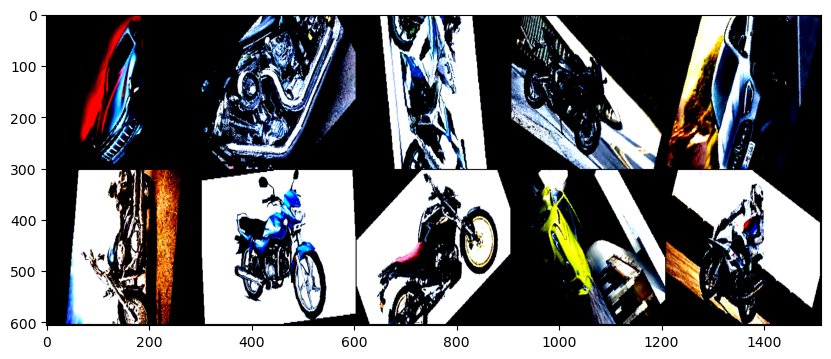

In [9]:
# Plot the interated images
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [12]:
# Utility function to count parameters for each model during training
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [13]:
# Utility function to train models
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    import time
    start_time = time.time()
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    model.to(device)
    criterion.to(device)

    for epoch in range(epochs):
        model.train()
        trn_corr = 0
        tst_corr = 0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch + 1}/{epochs}  Loss: {loss.item():.8f}  Accuracy: {trn_corr.item() * 100 / len(train_loader.dataset):.3f}%')

        loss = loss.detach().cpu().numpy()
        train_losses.append(loss)
        train_correct.append(trn_corr)

        model.eval()
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)

                y_val = model(X_test)
                predicted = torch.max(y_val.data, 1)[1]
                batch_corr = (predicted == y_test).sum()
                tst_corr += batch_corr

        loss = criterion(y_val, y_test)
        loss = loss.detach().cpu().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    return model


# Pretrained Models

In [14]:
# Download and load models
alexnetmodel= models.alexnet(pretrained=True)
alexnetmodel

# Freeze the CNN layers
for param in alexnetmodel.parameters():
    param.requires_grad=False

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [15]:
# Modify the classifier layers
alexnetmodel.classifier=nn.Sequential(nn.Linear(9216,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,2),
                                     nn.LogSoftmax(dim=1))

# Check the output size
alexnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [16]:
count_parameters(alexnetmodel)

 9437184
    1024
    2048
       2
________
 9440258


In [17]:
# Set the loss function and optimizer and train the model
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(alexnetmodel.classifier.parameters(),lr=0.001, weight_decay=0.01)
alexnetmodel = train(alexnetmodel, train_loader, test_loader, criterion, optimizer, device)

Epoch: 1/10  Loss: 0.02284118  Accuracy: 88.969%
Epoch: 2/10  Loss: 0.34330043  Accuracy: 93.531%
Epoch: 3/10  Loss: 0.53994286  Accuracy: 94.000%
Epoch: 4/10  Loss: 0.05373798  Accuracy: 94.062%
Epoch: 5/10  Loss: 0.02908338  Accuracy: 93.812%
Epoch: 6/10  Loss: 0.05897702  Accuracy: 93.844%
Epoch: 7/10  Loss: 0.32392338  Accuracy: 95.188%
Epoch: 8/10  Loss: 0.02541221  Accuracy: 95.344%
Epoch: 9/10  Loss: 0.08704191  Accuracy: 95.219%
Epoch: 10/10  Loss: 0.03798931  Accuracy: 94.875%

Duration: 316 seconds


In [18]:
# Save the trained model
torch.save(alexnetmodel.state_dict(), "/kaggle/working/alexnetpretrained.pt")

In [19]:
# Download and load models
densenetmodel= models.densenet121(pretrained=True)
densenetmodel

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
# Freeze the CNN layers
for param in densenetmodel.parameters():
    param.requires_grad=False

In [21]:
# Modify the classifier layers
densenetmodel.classifier=nn.Sequential(nn.Linear(1024,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,2),
                                     nn.LogSoftmax(dim=1))

# Check the output size
densenetmodel

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# Count the parameters during training
count_parameters(densenetmodel)

# Set the loss function and optimizer and train the model
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(densenetmodel.classifier.parameters(),lr=0.001, weight_decay=0.01)
densenetmodel = train(densenetmodel, train_loader, test_loader, criterion, optimizer, device)

 1048576
    1024
    2048
       2
________
 1051650
Epoch: 1/10  Loss: 0.08972023  Accuracy: 83.781%
Epoch: 2/10  Loss: 0.08265474  Accuracy: 90.250%
Epoch: 3/10  Loss: 0.04140576  Accuracy: 91.156%
Epoch: 4/10  Loss: 0.05948698  Accuracy: 92.719%
Epoch: 5/10  Loss: 0.13469882  Accuracy: 92.500%
Epoch: 6/10  Loss: 0.19540641  Accuracy: 91.938%
Epoch: 7/10  Loss: 0.16369781  Accuracy: 92.594%
Epoch: 8/10  Loss: 0.06533176  Accuracy: 92.000%
Epoch: 9/10  Loss: 0.14074478  Accuracy: 93.406%
Epoch: 10/10  Loss: 0.05199649  Accuracy: 92.844%

Duration: 400 seconds


In [24]:
# Save the trained model
torch.save(densenetmodel.state_dict(), "/kaggle/working/densenetpretrained.pt")

In [25]:
# Download and load models
efficientnetmodel= models.efficientnet_b0(pretrained=True)
efficientnetmodel

# Freeze the CNN layers
for param in efficientnetmodel.parameters():
    param.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [26]:
# Modify the classifier layers
efficientnetmodel.classifier=nn.Sequential(nn.Linear(1280,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,2),
                                     nn.LogSoftmax(dim=1))
# Check the output size
efficientnetmodel

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:
# Count the parameters during training
count_parameters(efficientnetmodel)

# Set the loss function and optimizer and train the model
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(efficientnetmodel.classifier.parameters(),lr=0.001, weight_decay=0.01)
efficientnetmodel = train(efficientnetmodel, train_loader, test_loader, criterion, optimizer, device)

 1310720
    1024
    2048
       2
________
 1313794
Epoch: 1/10  Loss: 0.38434142  Accuracy: 86.094%
Epoch: 2/10  Loss: 0.07756958  Accuracy: 89.969%
Epoch: 3/10  Loss: 0.06216909  Accuracy: 90.688%
Epoch: 4/10  Loss: 0.38554937  Accuracy: 90.562%
Epoch: 5/10  Loss: 0.27788383  Accuracy: 92.000%
Epoch: 6/10  Loss: 0.02446624  Accuracy: 91.844%
Epoch: 7/10  Loss: 0.03212679  Accuracy: 93.156%
Epoch: 8/10  Loss: 0.07406184  Accuracy: 91.906%
Epoch: 9/10  Loss: 0.10303506  Accuracy: 91.156%
Epoch: 10/10  Loss: 0.03470528  Accuracy: 92.531%

Duration: 344 seconds


In [28]:
# Save the trained model
torch.save(efficientnetmodel.state_dict(), "/kaggle/working/efficientnetpretrained.pt")